### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/Colab Notebooks/Homework2

/gdrive/My Drive/Colab Notebooks/Homework2


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from random import shuffle
import pickle
import warnings
import logging


plt.rc('font', size=16) 
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)

In [ ]:
x_dataset = np.load('x_train.npy')
y_dataset = np.load('y_train.npy')

In [ ]:
scaler = RobustScaler()
X_train_scaler = scaler.fit_transform(x_dataset.reshape(-1, x_dataset.shape[-1]))
x_dataset = X_train_scaler.reshape(x_dataset.shape)

file = open('scaler', 'wb')
pickle.dump(scaler, file)
file.close()


x_train_da, x_test_val, y_train_da, y_test_val = train_test_split(x_dataset, y_dataset, test_size=0.2, stratify=y_dataset)
# print(x_train_da.shape)
# print(y_train_da.shape)
# print('y_dataset:', Counter(y_dataset))
# print('y_train_da:', Counter(y_train_da))

#In order to exploit the whole dataset, the submitted models have been trained
#without a test set, the following two lines are kept for integrity.
# x_val_da = x_test_val
# y_val_da = y_test_val

x_test_da, x_val_da, y_test_da, y_val_da = train_test_split(x_test_val, y_test_val, test_size=0.5, stratify=y_test_val) #se aumento test_size aumento la percentuale di validation
# print(x_test_da.shape)
# print(y_test_da.shape)
# print(x_val_da.shape)
# print(y_val_da.shape)
# print('y_test_da:', Counter(y_test_da))
# print('y_val_da:', Counter(y_val_da))

In [ ]:
def oversampling(x_train, y_dataset):

  # print(x_train.shape)
  shape_x = x_train.shape[0]
  
  warnings.filterwarnings(action='ignore', category=DeprecationWarning)
  
  #The following ratio is aimed at mitigating the effect of the gap in different
  #amounts of samples between classes. However, to avoid overfitting, smallest 
  #classes have been oversampledof a factor not greater than 3.0
  ratio = {
            0 : ( (int) (Counter(y_train_da)[0] * 3.0)),
            1 : ( (int) (Counter(y_train_da)[1] * 1.2)),
            2 : ( (int) (Counter(y_train_da)[2] * 1.15)),
            3 : ( (int) (Counter(y_train_da)[3] * 1.25)),
            4 : ( (int) (Counter(y_train_da)[4] * 2.0)),
            5 : ( (int) (Counter(y_train_da)[5] * 1.2)),
            6 : ( (int) (Counter(y_train_da)[6] * 1.0)),
            7 : ( (int) (Counter(y_train_da)[7] * 1.75)),
            8 : ( (int) (Counter(y_train_da)[8] * 1.2)),
            9 : ( (int) (Counter(y_train_da)[9] * 1.0)),
            10 : ( (int) (Counter(y_train_da)[10] * 1.7)),
            11 : ( (int) (Counter(y_train_da)[11] * 2.0))  
           }
  count = 0
  for i in ratio.values():
    count += i
  #sampling_strategy=ratio
  sm = SMOTE(sampling_strategy=ratio)

  X_train_scaled_resahaped = x_train.reshape((-1, x_train.shape[0]))
  X_train_scaled_resahaped = X_train_scaled_resahaped.reshape((shape_x, 216))


  ### Resample X_train_scaled
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled_resahaped, y_dataset)
  # print(X_train_resampled.shape)
  # print(y_train_resampled.shape)
  #x_dataset = X_train_resampled.reshape((count, 36, 6))
  x_dataset = X_train_resampled.reshape((X_train_resampled.shape[0], 36, 6))
  # print(x_dataset.shape)

  # print('Original dataset shape:', Counter(y_dataset))
  # print('Resampled dataset shape:', Counter(y_train_resampled))
  # print(y_train_resampled.shape)

  return x_dataset, y_train_resampled

In [ ]:
x_train, y_train_dacat = oversampling(x_train_da, y_train_da)

y_train = tfk.utils.to_categorical(y_train_dacat)
y_val = tfk.utils.to_categorical(y_val_da)
y_test = tfk.utils.to_categorical(y_test_da)

#Additional reshuffle of every split

ind_list = [i for i in range(x_train.shape[0])]
shuffle(ind_list)
x_train = x_train[ind_list]
y_train = y_train[ind_list]

ind_list = [i for i in range(x_val_da.shape[0])]
shuffle(ind_list)
x_val_da = x_val_da[ind_list]
y_val = y_val[ind_list]

ind_list = [i for i in range(x_test_da.shape[0])]
shuffle(ind_list)
x_test_da = x_test_da[ind_list]
y_test = y_test[ind_list]

In [ ]:
def add_noise(signal):
    noise = np.random.normal(0, 1, signal.shape)
    return signal + noise
def scale(signal):
    scaling_factor = np.random.uniform(0.5, 1.5)
    return signal * scaling_factor
# Time shifting: Shift the signal along the time axis by a random number of samples.
def time_shift(signal):
    shift = np.random.randint(-5, 5)
    return np.roll(signal, shift, axis=0)
# Vertical shifting: Shift the signal along the vertical axis by a random amount.
def vertical_shift(signal):
    shift = np.random.uniform(-1, 1)
    return signal + shift
# Random cropping: Select a random portion of the signal and return it. 
#This can be done by using the np.random.randint function to generate random indices for the start and end of the crop,
# and then using these indices to slice the signal.
def random_crop(signal):
    start = np.random.randint(0, signal.shape[0] - 10)
    end = start + np.random.randint(10, signal.shape[0] - start)
    return signal[start:end]

In [ ]:
def aug_time_series(time_series):
  add_noise(time_series)
  scale(time_series)
  time_shift(time_series)
  vertical_shift(time_series)
  random_crop(time_series)

#Data Augmentation is applied on the training set only
aug_time_series(x_train)

### Build and train models

In [ ]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
units = 512

# Map activities to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11
}

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs
)

In [ ]:
#In the best model this architecture actually is not included, this is kept for integrity

def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(units, return_sequences=True)(input_layer)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)

    lstm = tfkl.LSTM(units,return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)

    lstm = tfkl.LSTM(units, return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)
    
    lstm = tfkl.LSTM(units)(lstm)
    
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)

    output_layer = tfkl.Dense(classes, activation='softmax')(lstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

def build_RNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #noise = tf.keras.layers.GaussianNoise(0.05)(input_layer)

    # Feature extractor
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    rnn = tfkl.GRU(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.GRU(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    #The insertion of a final SimpleRNN layer attcached to the GRU layers is on 
    # purpose as it suffered less overfitting
    rnn = tfkl.SimpleRNN(units, return_sequences=False)(rnn)
    rnn = tfkl.Dropout(0.6, seed=seed)(rnn)

    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)

    output_layer = tfkl.Dense(classes, activation='softmax')(rnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model



def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(input_layer)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(bilstm)
    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units))(bilstm)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    # Classifier
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    output_layer = tfkl.Dense(classes, activation='softmax')(bilstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model




def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    # Classifier
    
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    cnn = tfkl.Dense(128, activation='relu')(cnn)
    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model


def build_CNN_BILSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    cnn = tfkl.Dropout(.1, seed=seed)(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)
    # Classifier
    
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)


    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# model.save('LSTM_6904')

In [ ]:
# train models and keep them in memory

models = list()

# model = build_LSTM_classifier(input_shape, classes)
# models.append(model)

model = build_RNN_classifier(input_shape, classes)
models.append(model)

model = build_BiLSTM_classifier(input_shape, classes)
models.append(model)

model = build_1DCNN_classifier(input_shape, classes)
models.append(model)

model = build_CNN_BILSTM_classifier(input_shape, classes)
models.append(model)

epochs = 150

for i in range(len(models)):
  models[i].fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_data = (x_val_da,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
        ]
    )

Epoch 1/150
20/20 [==============================] - 5s 88ms/step - loss: 2.1355 - accuracy: 0.2854 - val_loss: 1.9791 - val_accuracy: 0.3825 - lr: 0.0010
Epoch 2/150
20/20 [==============================] - 1s 50ms/step - loss: 2.0362 - accuracy: 0.3227 - val_loss: 1.8521 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 3/150
20/20 [==============================] - 1s 51ms/step - loss: 1.9418 - accuracy: 0.3461 - val_loss: 1.6624 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 4/150
20/20 [==============================] - 1s 50ms/step - loss: 1.7962 - accuracy: 0.3666 - val_loss: 1.5736 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 5/150
20/20 [==============================] - 1s 51ms/step - loss: 1.7120 - accuracy: 0.4084 - val_loss: 1.4407 - val_accuracy: 0.5246 - lr: 0.0010
Epoch 6/150
20/20 [==============================] - 1s 50ms/step - loss: 1.6476 - accuracy: 0.4361 - val_loss: 1.3895 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 7/150
20/20 [==============================] - 1s 50ms/step - lo

6/6 [==============================] - 1s 7ms/step
0 :
Accuracy: 0.6538
Precision: 0.5085
Recall: 0.5083
F1: 0.5025
1 :
Accuracy: 0.6264
Precision: 0.6231
Recall: 0.577
F1: 0.5811
2 :
Accuracy: 0.6374
Precision: 0.6585
Recall: 0.5347
F1: 0.5572
3 :
Accuracy: 0.7253
Precision: 0.7609
Recall: 0.6076
F1: 0.6396


ENSEMBLE:
Accuracy: 0.7418
Precision: 0.7828
Recall: 0.6362
F1: 0.6777


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


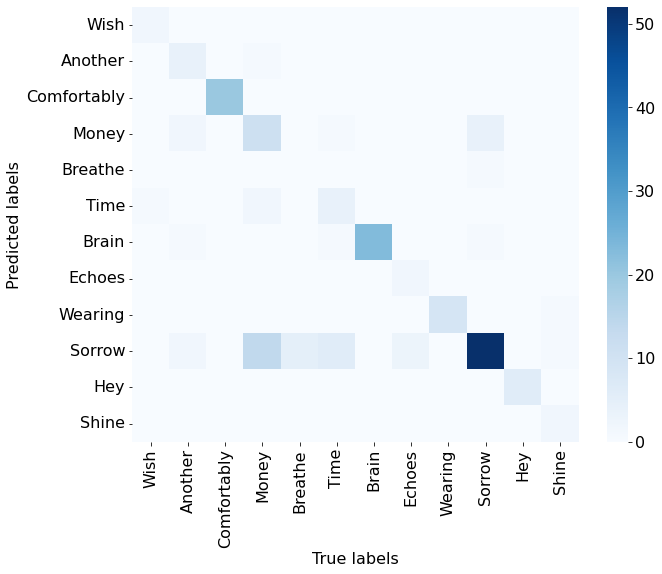

In [ ]:
#Predictions on the local dataset of single models
yhats = [model.predict(x_test_da) for model in models]
yhats = np.array(yhats)

for i in range(len(yhats)):
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  print(i,':')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))



#Predictions on the local dataset of the Ensemble method
predictions = np.mean(yhats, axis=0)

accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('\n\nENSEMBLE:')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

#Confusion matrix of the ensemble method
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
#To submit the best model for each architecture we saved at each time by hand only in case of good performances
# models[0].save('model0')
# models[1].save('model0')
# models[2].save('model0')
# models[3].save('model0')
# models[4].save('model0')